# Supervisely Python SDK Tutorial #3: Augmentations

This tutorial covers the image augmentations available in the Supevisely Python SDK. Augmentations are image transformations that preserve the essence of the image content: a cat shifted 100 pixels to the left is still a cat. Augmenting the input data is the standard approach to add diversity to the training data for a neural network without having to acquire and manually label more training images.

In our SDK, there are two modules that contain augmentation functions:
* `aug` module contains augmentations that affect the spatial properties of the image: random crops, rotations etc. When objects move around in the image, it is important to modify the annotation in exactly the same way to keep the labels aligned with the modified image. To make sure the the same transformation is applied to both the image and its annotation, the augmentations are done jointly on an image - annotation pair.
* `imaging.image` contains image-only augmentations that *preserve the spatial structure* of the image, such as contrast or brightness changes or injecting noise into the pixels colors. Since none of the objects in the image move with such changes, the original annotations can be safely reused with the augmented image.

In this tutorial we simply go over the available augmentations and visualize their results.

# Imports

### Required imports

In [1]:
import supervisely_lib as sly  # Supervisely Python SDK

# Matplotlib for rendering images in Jupyter.
%matplotlib inline
import matplotlib.pyplot as plt

## Prepare sample input

Here we read an example image - annotation pair from a provided Supervisely project and define convenience helpers for visualizing the results

### Load input data

Check out our Tutorial #1 for an in-depth guide on working with on-disk projects and labeling data via Supervisely SDK.

In [2]:
project = sly.Project('./tutorial_project', sly.OpenMode.READ)
img_path, ann_path = project.datasets.get("dataset_01").get_item_paths("image_01")
img = sly.image.read(img_path)
ann = sly.Annotation.load_json_file(ann_path, project.meta)

### Define visualization helpers
We will display the original image, overlayed filled labeled objects, and object contours.

In [3]:
#helper function to draw image and annotation
def draw_labeled_image(img, ann):
    canvas_draw = img.copy()
    canvas_draw_contour = img.copy()
    ann.draw(canvas_draw)
    ann.draw_contour(canvas_draw_contour, thickness=4)
    
    fig = plt.figure(figsize=(20, 20))
    #plt.suptitle(title, fontsize=20)
    
    fig.add_subplot(1, 3, 1)
    plt.imshow(img)
    
    fig.add_subplot(1, 3, 2)
    plt.imshow(canvas_draw)
    
    fig.add_subplot(1, 3, 3)
    plt.imshow(canvas_draw_contour)
    
    plt.show()

### Original image and its annotation

First let us check out the loaded input image and the labels we have for it. Notice we have multiple label types in one image:
* A rectangle bounding box for the motorcycle.
* A binary bitmap mask for the person.
* A polygonal contour for the dog.
This will let us see how the different lable types behave during augmentations.

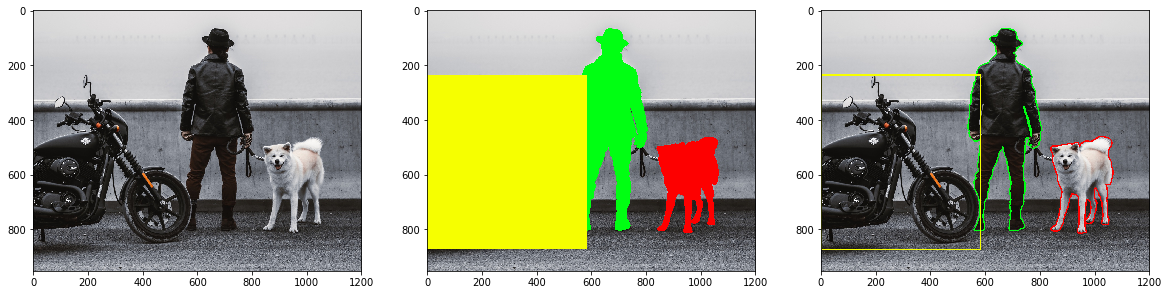

In [4]:
draw_labeled_image(img, ann)

## Spatial augmentations

These affect both the image and its annotation.

### Horizontal flip (left-right)

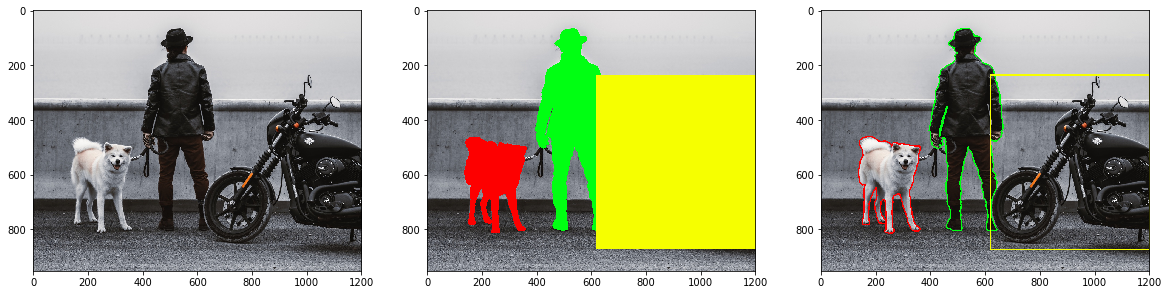

In [5]:
flipped_img, flipped_ann = sly.aug.fliplr(img, ann)
draw_labeled_image(flipped_img, flipped_ann)

### Vertical flip

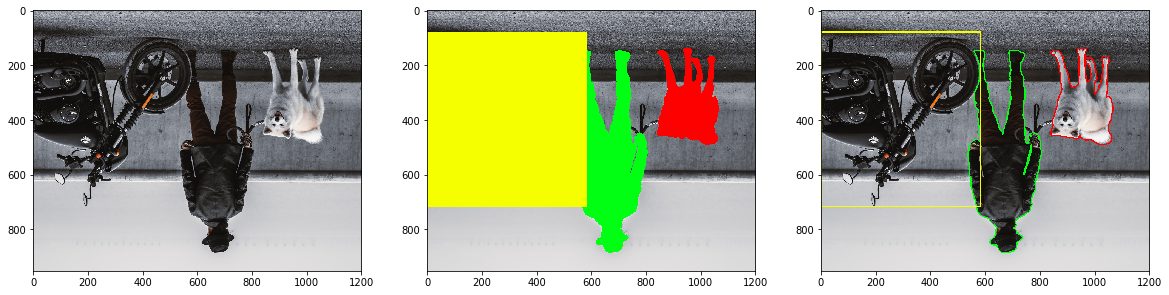

In [6]:
flipped_img, flipped_ann = sly.aug.flipud(img, ann)
draw_labeled_image(flipped_img, flipped_ann)

### Random crop - height and width from range

Here we provide ranges of what fraction (between 0 and 1) of each dimension to keep. The cropping functions first samples effective exact fractions uniformly from those ranges, which defines the size of the cropping window. Then that cropping window is uniformly randomly placed onto the original image to produce the crop.

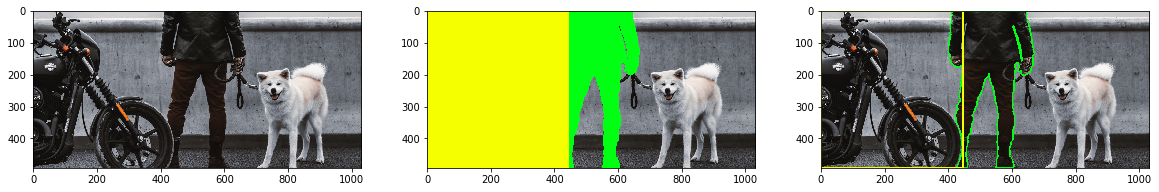

In [7]:
cropped_img, cropped_ann = sly.aug.random_crop_fraction(
    img, ann, height_fraction_range=(0.5, 0.7), width_fraction_range=(0.5, 0.9))
draw_labeled_image(cropped_img, cropped_ann)

### Random crop - fixed height and width

In this version of the random crop we set the exact height and width of the cropping window in pixels. The window is then placed uniformly at random onto the original image.

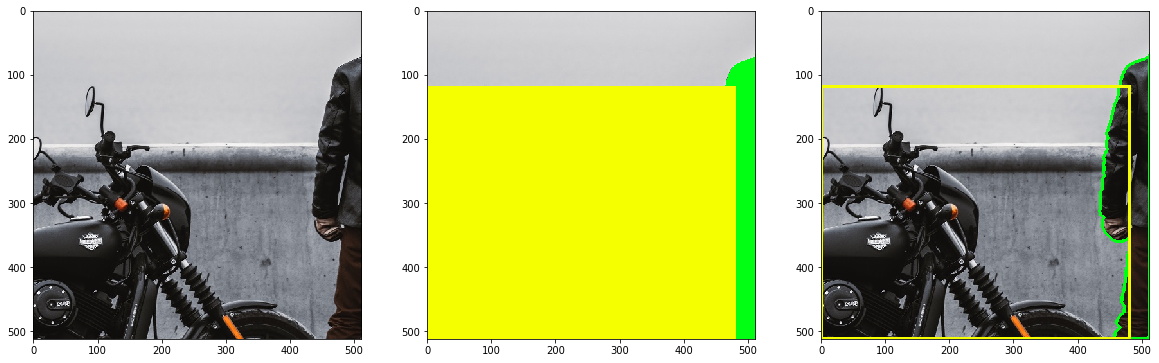

In [8]:
cropped_img, cropped_ann = sly.aug.random_crop(img, ann, height=512, width=512)
draw_labeled_image(cropped_img, cropped_ann)

### Deterministic crop (relative units)

Specify the amount to crop off from every side in fractions of the full original image side.

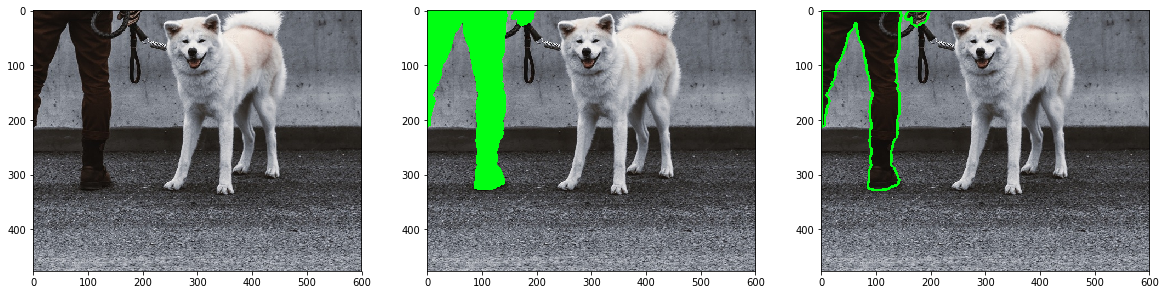

In [9]:
# crop right quarter of the image
cropped_img, cropped_ann = sly.aug.crop_fraction(img, ann, top=0.5, left=0.5, bottom=0, right=0)
draw_labeled_image(cropped_img, cropped_ann)

### Deterministic crop (absolute pixels)

Specify the amount to crop off from every side in pixels.

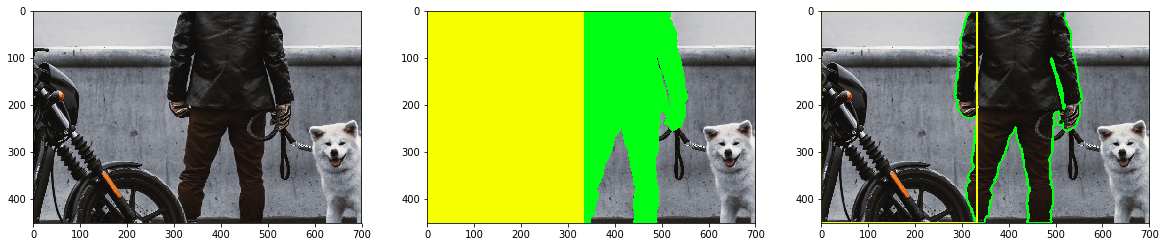

In [10]:
# crop right quarter of the image
cropped_img, cropped_ann = sly.aug.crop(img, ann, top_pad=250, left_pad=250, bottom_pad=250, right_pad=250)
draw_labeled_image(cropped_img, cropped_ann)

### Resize

Resize to a given image size, in pixels. The size should be a tuple (or list or compatible object) of `(height, width)` format. So in particular a Numpy array shape can be used as the size argument here.

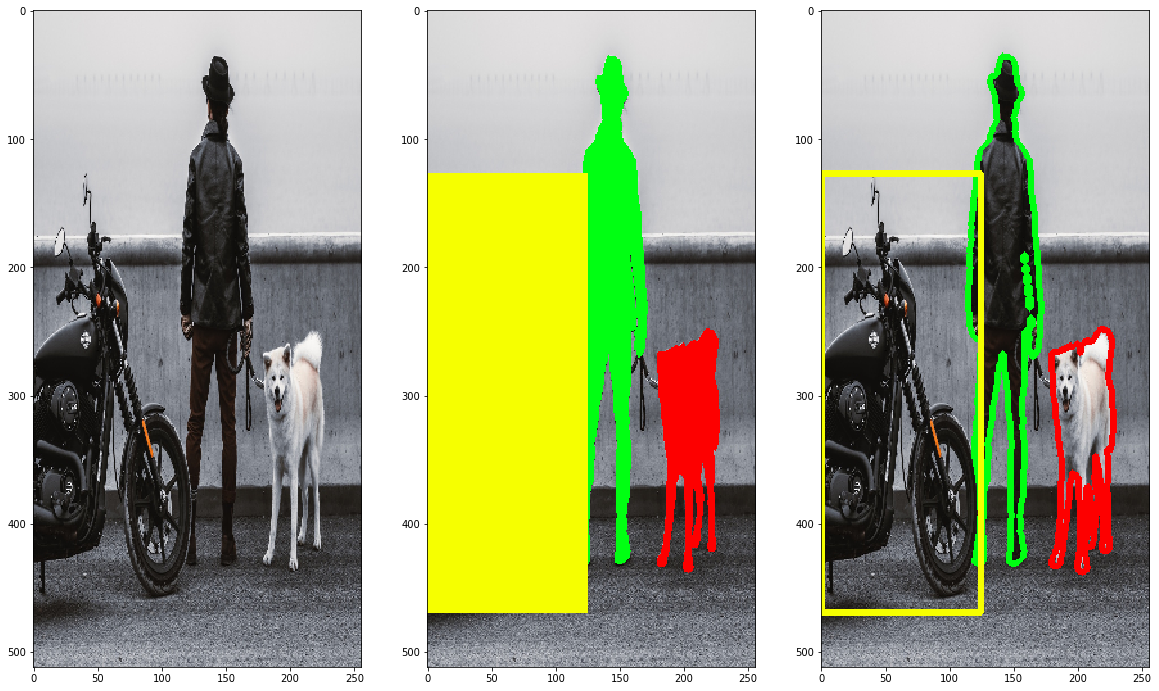

In [14]:
resized_img, resized_ann = sly.aug.resize(img, ann, size=(512, 256))
draw_labeled_image(resized_img, resized_ann)

### Scale proportionally

Scale by a given factor.

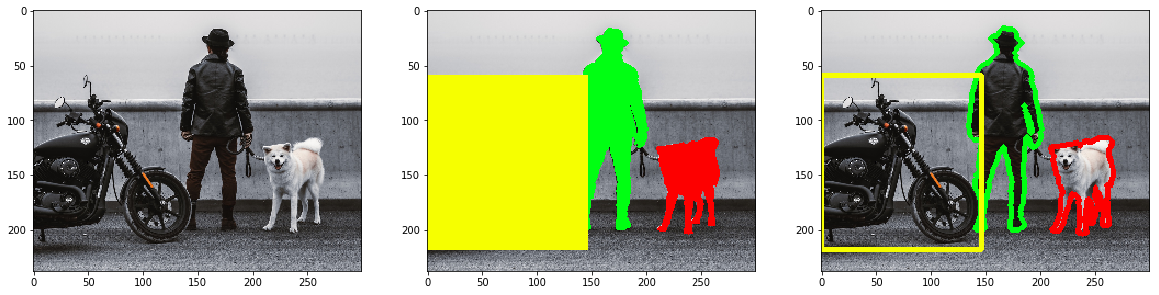

In [15]:
resized_img, resized_ann = sly.aug.scale(img, ann, f=0.25)
draw_labeled_image(resized_img, resized_ann)

### Rotate (with padding)

Rotate the image by the given number of degrees (counter-clockwise). Grow the canvas to contain the full rotated image. Fill the rest of the canvas with black.

Note that rectangles are handled in a special way during rotations. Since rectangles are required to be axis-aligned, we cannot simply save a rotated rectangle. Instead, a rotated rectangle is replaced by its axis-aligned bounding box. So every rotation (unless by a multiple of 90 degrees) enlarges the rectangle labels.

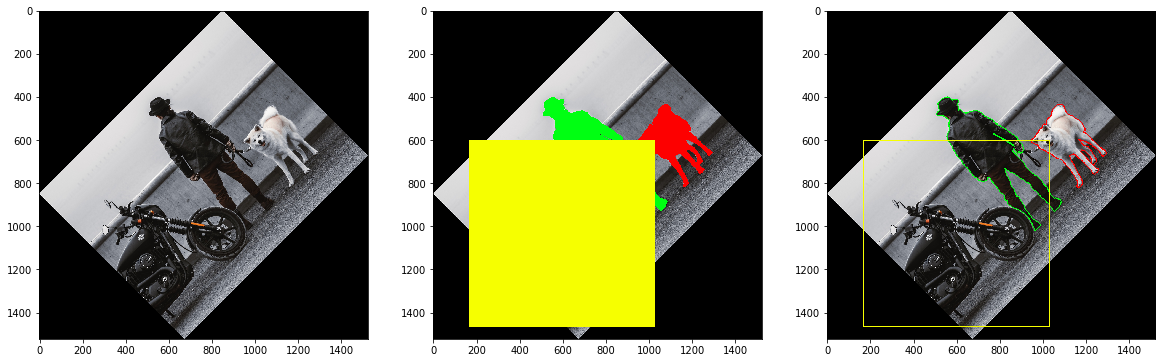

In [16]:
rotated_img, rotated_ann = sly.aug.rotate(img, ann, degrees=45, mode=sly.aug.RotationModes.KEEP)
draw_labeled_image(rotated_img, rotated_ann)

### Rotate (without padding)

Rotate the image by the given number of degrees (counter-clockwise). Find the largest axis-aligned rectangle that fits inside the rotated image and crop to that rectangle. In this mode all the pixel of the resulting image are colord according to the original image, so there is no arbitrary-colored padding.

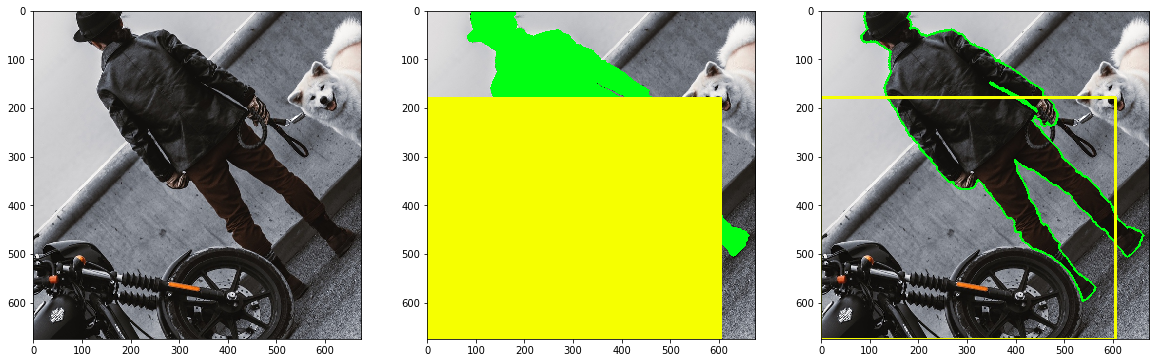

In [17]:
rotated_img, rotated_ann = sly.aug.rotate(img, ann, degrees=45, mode=sly.aug.RotationModes.CROP)
draw_labeled_image(rotated_img, rotated_ann)

## Per-pixel augmentations

These do not move the image, so the original annotation is still applicable to the augmented image.

### Random brightness

Scales the individual pixel values by a fixed factor (same for all the pixels in the image), sampled uniformly from the range given by the arguments.

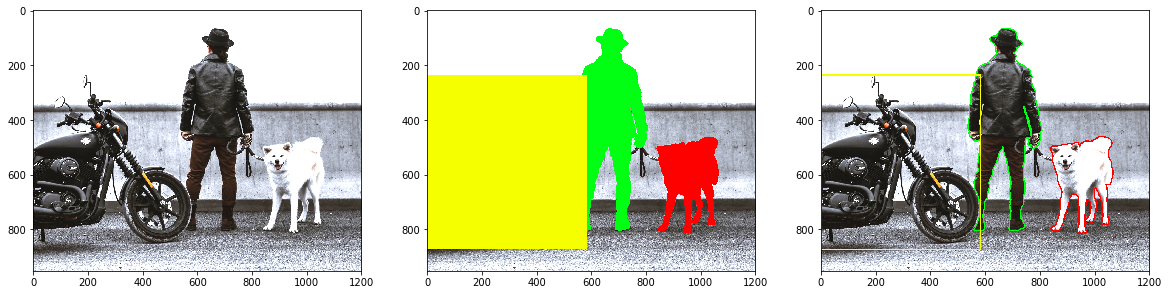

In [18]:
aug_img = sly.image.random_brightness(img, min_factor=1, max_factor=2)
draw_labeled_image(aug_img, ann)

### Random contrast

Converts input image to grayscale and transforms each pixel brightness as `x_augmented = (x - image_mean) * factor + image_mean`, where `image_mean` is the average brightness for the whole image and `factor` is sampled uniformly from the given range (same for all the pixels).

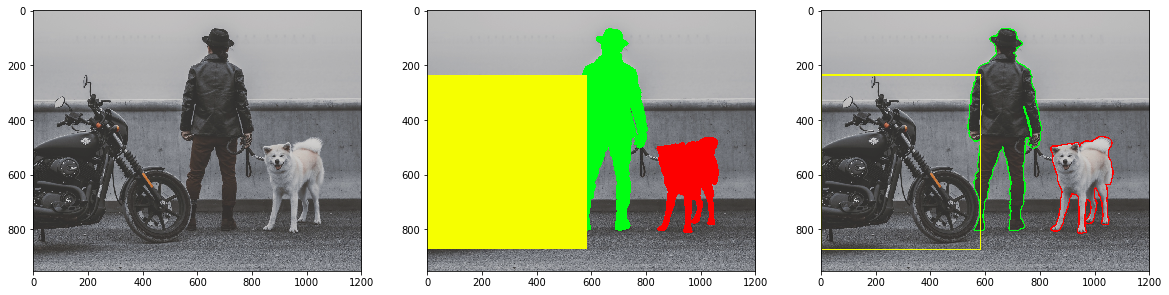

In [19]:
aug_img = sly.image.random_contrast(img, min_factor=0.5, max_factor=0.7)
draw_labeled_image(aug_img, ann)

### Random Gaussian noise

Add independent per-pixel random Gaussian noise.

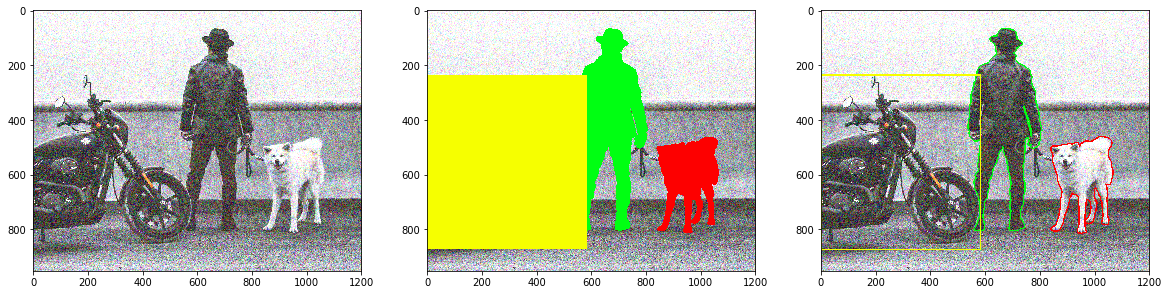

In [20]:
aug_img = sly.image.random_noise(img, mean=50, std=35)
draw_labeled_image(aug_img, ann)

### Random per-color scale

Scale the brighness independently for each of the color channels. The scaling factors are sampled uniformly from the given range.

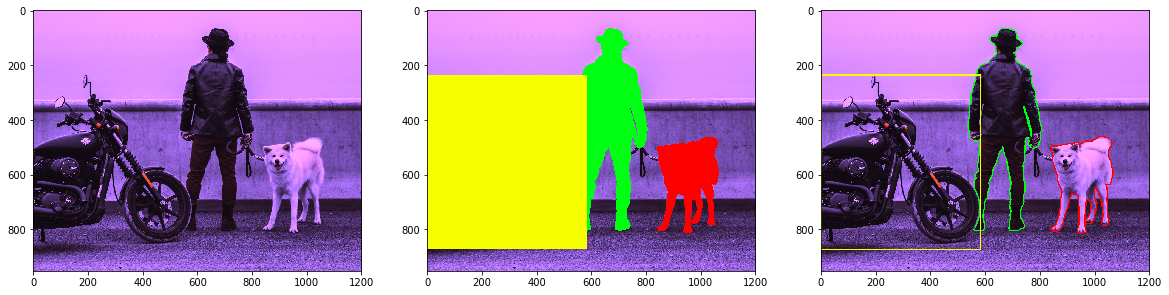

In [21]:
aug_img = sly.image.random_color_scale(img, min_factor=0.5, max_factor=1.8)
draw_labeled_image(aug_img, ann)

### Blur

Blur with a uniform square kernel of a given size.

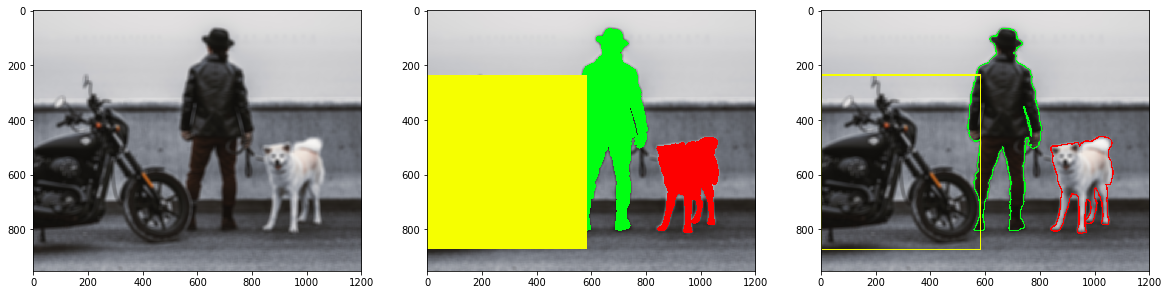

In [22]:
aug_img = sly.image.blur(img, kernel_size=15)
draw_labeled_image(aug_img, ann)

### Median Blur

Blurs with a square median filter of a given size.

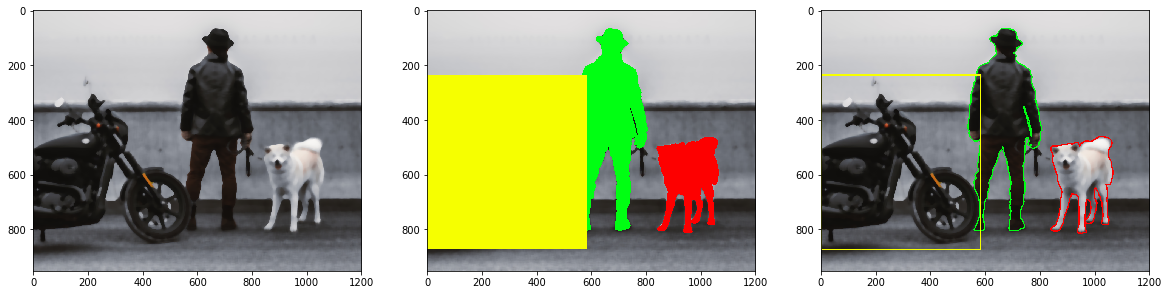

In [23]:
aug_img = sly.image.median_blur(img, kernel_size=15)
draw_labeled_image(aug_img, ann)

### Gaussian Blur

Blurs with a square uniform Gaussian kernel with standard deviation sampled uniformly from the given range. The kernel size is determined from the sampled standard deviation.

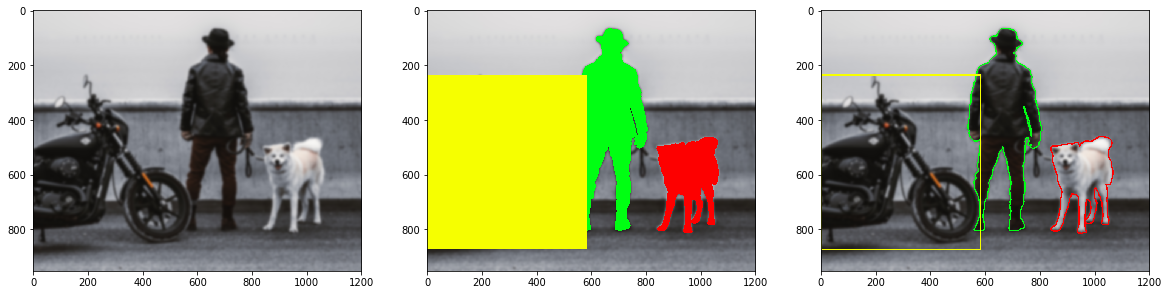

In [24]:
aug_img = sly.image.gaussian_blur(img, sigma_min=1, sigma_max=15)
draw_labeled_image(aug_img, ann)